<a href="https://colab.research.google.com/github/yifan-zhou19/iso/blob/master/iso_cg_model(ffnn_lstm_cnn).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import torch
cuda = True if torch.cuda.is_available() else False
print(cuda)
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

True
cuda:0


In [4]:
##################
# DATA IMPORTING #
##################

from os.path import exists

!wget -O cwe119_cgd.txt https://raw.githubusercontent.com/CGCL-codes/VulDeePecker/master/CWE-119/CGD/cwe119_cgd.txt

print()

with open("./cwe119_cgd.txt", "r") as cgd:
  print("Source: ",cgd.readline())

--2020-04-28 12:17:32--  https://raw.githubusercontent.com/CGCL-codes/VulDeePecker/master/CWE-119/CGD/cwe119_cgd.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17202057 (16M) [text/plain]
Saving to: ‘cwe119_cgd.txt’

cwe119_cgd.txt      100%[===================>]  16.40M  53.5MB/s    in 0.3s    

2020-04-28 12:17:34 (53.5 MB/s) - ‘cwe119_cgd.txt’ saved [17202057/17202057]


Source:  1 CVE-2010-1444/vlc_media_player_1.1.0_CVE-2010-1444_zipstream.c cfunc 449



In [86]:
import re
re_punctuation_string = '[()\s,/.\']'
programs=[]
program = []
statement=[]
labels = []
vocabulary = [] 
remove_token=['',' ',',','NULL','\n',';']
with open("./cwe119_cgd.txt", "r") as cgd:
  lines = cgd.readlines()
  for line in lines:
    statement=[token for token in re.split(re_punctuation_string,line)if token not in remove_token]
    #print(statement)
    if statement == ['---------------------------------']:
      if program[-1] == ['0']:
        labels.append(0)
      elif program[-1] == ['1']:
        labels.append(1)
      programs.append(program[1:-2])
      for s in program[1:]:
        for t in s:
           if t not in vocabulary:
             vocabulary.append(t)
      #print(program)
      program = []
    else:
      program.append(statement)

print(len(labels))


  
print(len(vocabulary))
   

39753
22631


In [0]:
# shuffle data
import random
randnum = random.randint(0,100)
random.seed(randnum)
random.shuffle(programs)
random.seed(randnum)
random.shuffle(labels)

In [88]:
#print(vocabulary[:20])
print(len([one for one in labels[:10000] if one == 1 ]))
print(len([zero for zero in labels[:10000] if zero == 0 ]))

2613
7387


In [89]:
print(len([one for one in labels[10000:15000] if one == 1 ]))
print(len([zero for zero in labels[10000:15000] if zero == 0]))


1318
3682


In [90]:
training_data = []
for i in range(10000):
  training_data.append((programs[i],labels[i]))
print(training_data[:2])

[([['#ifdef', '_WIN32'], ['#define', 'SNPRINTF', '_snprintf'], ['#else'], ['#define', 'SNPRINTF', 'snprintf'], ['#endif'], ['char', '*', '*dataPtr1', '=', '&data;'], ['char', '*', '*dataPtr2', '=', '&data;'], ['char', 'dataBuffer[100]', '=', '"";'], ['data', '=', 'dataBuffer;'], ['char', '*', 'data', '=', '*dataPtr1;'], ['size_t', 'dataLen', '=', 'strlen', 'data'], ['if', '100-dataLen', '>', '1'], ['if', 'fgets', 'data+dataLen', 'int', '100-dataLen', 'stdin', '!='], ['dataLen', '=', 'strlen', 'data'], ['if', 'dataLen', '>', '0', '&&', 'data[dataLen-1]', '==', '\\n'], ['data[dataLen-1]', '=', '\\0'], ['else'], ['data[dataLen]', '=', '\\0'], ['*dataPtr1', '=', 'data;'], ['char', '*', 'data', '=', '*dataPtr2;'], ['char', 'dest[100]', '=', '"";']], 0), ([['ss_tc_root', '=', 'getenv', '"SS_TC_ROOT"'], ['if', 'ss_tc_root', '!=', '{'], ['size_dirpath', '=', 'strlen', 'ss_tc_root', '+', 'strlen', '"testData"', '+', '2;'], ['dirpath', '=', 'char*', 'malloc', 'size_dirpath', '*', 'sizeof', 'char

In [91]:
eval_data=[]
for i in range(10000,15000):
  eval_data.append((programs[i],labels[i]))
print(eval_data[:2])

[([['if', 'getenv', '"STONESOUP_DISABLE_WEAKNESS"', '==', '||']], 0), ([['ss_tc_root', '=', 'getenv', '"SS_TC_ROOT"'], ['size_dirpath', '=', 'strlen', 'ss_tc_root', '+', 'strlen', '"testData"', '+', '2;'], ['dirpath', '=', 'char*', 'malloc', 'size_dirpath', '*', 'sizeof', 'char'], ['sprintf', 'dirpath', '"%s', '%s"', 'ss_tc_root', '"testData"'], ['if', 'stat', 'dirpath', '&st', '==', '-1', '{'], ['retval', '=', 'mkdir', 'dirpath', '0700'], ['size_filepath', '=', 'strlen', 'dirpath', '+', 'strlen', '"logfile', 'txt"', '+', '2;'], ['sprintf', 'filepath', '"%s', '%s"', 'dirpath', '"logfile', 'txt"']], 0)]


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#look up table  
#using one-hot embedding
vocabulary_size = len(vocabulary)
def look_up_table(word_idx):
  x = torch.zeros(vocabulary_size).long()
  x[word_idx] = 1.0
  return x
word2idx = {w: idx +1 for (idx, w) in enumerate(vocabulary)}
idx2word = {idx+1: w for (idx, w) in enumerate(vocabulary)}
print(look_up_table(word2idx['1']))

tensor([0, 0, 0,  ..., 0, 0, 0])


In [0]:

context_size = 50
def get_programcontext(program):
  id = 0
  contexts =torch.zeros(context_size,1).long()
  for p in program:
    for t in p:
      if id < context_size:
        contexts[id]= word2idx[t]
        id = id +1
      else:
        return contexts
  return contexts
#get_programcontext(programs[0])

In [156]:
max_len = 0
mean_len = 0
l_big = 0
l_small = 0
for p in programs:
  con= get_programcontext(p)
  if con[context_size-1]>0:
    l_big = l_big +1
  else:
    l_small = l_small +1

  #print(l)

print(l_big/len(programs))
print(l_small/len(programs))

0.17659044600407517
0.8234095539959249


In [157]:


torch.manual_seed(1)
embedding_dim =10

hidden_dim=5
class FFNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(FFNN, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.linear1 = nn.Linear(embedding_dim*context_size,hidden_dim)
    self.linear2 = nn.Linear(hidden_dim,2)
  def forward(self, inputs):
    #print(inputs.size())
    if torch.cuda.is_available():
      embeds = self.embeddings(inputs.view(-1).cuda())
      out = F.relu(self.linear1(embeds.view(-1))).cuda()
      out = F.softmax(self.linear2(out),dim=0).cuda()
    else:
      embeds = self.embeddings(inputs.view(-1))
    #print(embeds)
      out = F.relu(self.linear1(embeds.view(-1)))
      out = F.softmax(self.linear2(out),dim=0)
    return out






loss_function = nn.BCELoss()
model_ffnn = FFNN(vocabulary_size, embedding_dim)
if torch.cuda.is_available():
    model_ffnn.cuda()
    
optimizer_ffnn = optim.Adam(model_ffnn.parameters(), lr=0.001)
params = sum(p.numel() for p in model_ffnn.parameters() if p.requires_grad)
print("Total number of parameters for FFNN is: {}".format(params))





Total number of parameters for FFNN is: 228827


In [166]:

torch.manual_seed(1)
embedding_dim =10

class CNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(CNN, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.conv1 = nn.Conv1d(1, 10, (5,embedding_dim),padding =(2,0))
    self.conv2 = nn.Conv2d(10, 4, (3,1))
    self.fc1 = nn.Linear(192, 2)

  def forward(self, inputs):
    if torch.cuda.is_available():
    #print(inputs.size())
      embeds = self.embeddings(inputs.view(-1).cuda())
    #print(embeds.size())
      out = self.conv1(embeds.view(1,1,context_size,embedding_dim)).cuda()
    #print(out.size())
      out = self.conv2(out).cuda()
    #print(out.size())
      out = F.softmax(self.fc1(out.view(-1)),dim=0).cuda()
    else:
      #print(inputs.size())
      embeds = self.embeddings(inputs.view(-1))
    #print(embeds.size())
      out = self.conv1(embeds.view(1,1,context_size,embedding_dim))
    #print(out.size())
      out = self.conv2(out)
    #print(out.size())
      out = F.softmax(self.fc1(out.view(-1)),dim=0)
    return out

model_cnn = CNN(vocabulary_size, embedding_dim)
if torch.cuda.is_available():
    model_cnn.cuda()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print("Total number of parameters for CNN is: {}".format(params))

Total number of parameters for CNN is: 227330


In [160]:

torch.manual_seed(1)
embedding_dim =10

hidden_dim=5



class LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(LSTM, self).__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim)
    self.fc1 = nn.Linear(hidden_dim, 2)

  def forward(self, inputs):
    if torch.cuda.is_available():
    #print(inputs.size())
      embeds = self.embeddings(inputs.cuda())
    #print(embeds.size())
      lstm_out, _ = self.lstm(embeds.view(len(inputs), 1, -1).cuda())
    #print(out.size())
      out =  self.fc1(lstm_out.view(len(inputs), -1)).cuda()
    #print(out.size())
      out = F.softmax(out,dim=1).cuda()
    else:
    #print(inputs.size())
      embeds = self.embeddings(inputs)
    #print(embeds.size())
      lstm_out, _ = self.lstm(embeds.view(len(inputs), 1, -1))
    #print(out.size())
      out =  self.fc1(lstm_out.view(len(inputs), -1))
    #print(out.size())
      out = F.softmax(out,dim=1)
    return out[-1]

model_lstm = LSTM(vocabulary_size, embedding_dim)
if torch.cuda.is_available():
    model_lstm.cuda()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)
params = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)
print("Total number of parameters for LSTM is: {}".format(params))

Total number of parameters for LSTM is: 226662


In [158]:
loss_ffnn=[]
for epoch in range(20):
  losses = 0
  for program, label in training_data:
   # print(program)
   # print(label)
   if label ==1:
     out_labels = torch.FloatTensor([0,1])
   else:
     out_labels  = torch.FloatTensor([1,0])  
   context_idx = get_programcontext(program)
   model_ffnn.zero_grad()
   out = model_ffnn(context_idx)
   #print(out.size())
   #print(f'Out {out}')
   #print(out_labels)
   if torch.cuda.is_available():
     loss = loss_function(out, out_labels.cuda())
   else:
     loss = loss_function(out, out_labels)
   if torch.cuda.is_available():
     loss.cuda()
   #print(f'Loss {loss.item()}')
   loss.backward()
   optimizer_ffnn.step()
   #print(f'Loss {loss.item()}')
   losses +=loss.item()
  print(f'Loss at epo {epoch}: {losses/len(training_data)}')
  loss_ffnn.append(losses/len(training_data))

Loss at epo 0: 0.42971116589719605
Loss at epo 1: 0.2582435409383385
Loss at epo 2: 0.18491887092482567
Loss at epo 3: 0.15068261167981123
Loss at epo 4: 0.1309617747233993
Loss at epo 5: 0.11999687827103692
Loss at epo 6: 0.11233798295292577
Loss at epo 7: 0.10558565787909772
Loss at epo 8: 0.10230210890999754
Loss at epo 9: 0.0963687245455439
Loss at epo 10: 0.0925347222631172
Loss at epo 11: 0.0916629306057925
Loss at epo 12: 0.08723066297210733
Loss at epo 13: 0.08598972930025602
Loss at epo 14: 0.08249444548074546
Loss at epo 15: 0.08161436874649021
Loss at epo 16: 0.08010981079356272
Loss at epo 17: 0.07913462731962452
Loss at epo 18: 0.07680514909450502
Loss at epo 19: 0.07661029042589779


In [159]:
with torch.no_grad():
  tp=0
  tn=0
  fp=0 
  fn = 0
  for program, label in eval_data:
   # print(program)
   # print(label)
   context_idx = get_programcontext(program)
   model_ffnn.zero_grad()
   out = model_ffnn(context_idx)
   #print(f'{out}:{label}')
   if(out[0]>0.5):
     if(label == 0):
       tn =tn+1
     else:
       fp = fp +1
   elif(out[1]>0.5):
     if(label == 1):
       tp = tp+1
     else:
       fn = fn +1
  accu=(tn+tp)/(tp+tn+fn+fp)
  pre=tp/(tp+fp)
  re=tp/(tp+fn)
  print(f'Accuracy_ffnn: {accu}') 
  print(f'Precision_ffnn: {pre}')
  print(f'Recall_ffnn: {re}')
  print(f'F1_ffnn: {2*(pre*re/(pre+re))}')  

Accuracy_ffnn: 0.9188
Precision_ffnn: 0.8141122913505311
Recall_ffnn: 0.8695299837925445
F1_ffnn: 0.8409090909090909


In [167]:
loss_cnn=[]
for epoch in range(20):
  losses = 0
  for program, label in training_data:
   # print(program)
   # print(label)
   if label ==1:
     out_labels = torch.FloatTensor([0,1])
   else:
     out_labels  = torch.FloatTensor([1,0])

   context_idx = get_programcontext(program)
   model_cnn.zero_grad()
   out = model_cnn(context_idx)
   if torch.cuda.is_available():
     loss = loss_function(out, out_labels.cuda())
   else:
     loss = loss_function(out, out_labels)
   if torch.cuda.is_available():
     loss.cuda()

   #print(out.size())
   #print(f'Out {out}')
   #print(out_labels)
   #print(f'Loss {loss.item()}')
   loss.backward()
   optimizer_cnn.step()
   #print(f'Loss {loss.item()}')
   losses +=loss.item()
  print(f'Loss at epo {epoch}: {losses/len(training_data)}')
  loss_cnn.append(losses/len(training_data))

Loss at epo 0: 0.41697519065833005
Loss at epo 1: 0.2683435124128308
Loss at epo 2: 0.2153988377843374
Loss at epo 3: 0.18634405876291313
Loss at epo 4: 0.1676637099212482
Loss at epo 5: 0.15436617898875915
Loss at epo 6: 0.1440694310014126
Loss at epo 7: 0.13564873832394286
Loss at epo 8: 0.12869896073906587
Loss at epo 9: 0.12316978408126575
Loss at epo 10: 0.1185675874163119
Loss at epo 11: 0.11457015662503031
Loss at epo 12: 0.11110988775771512
Loss at epo 13: 0.10809673256734142
Loss at epo 14: 0.105500174570571
Loss at epo 15: 0.10318725925782003
Loss at epo 16: 0.10106878665449996
Loss at epo 17: 0.0992946695607472
Loss at epo 18: 0.09771117342129242
Loss at epo 19: 0.0959618792160113


In [168]:
with torch.no_grad():
  tp=0
  tn=0
  fp=0 
  fn = 0
  for program, label in eval_data:
   # print(program)
   # print(label)
   context_idx = get_programcontext(program)
   model_cnn.zero_grad()
   out = model_cnn(context_idx)
   #print(f'{out}:{label}')
   if(out[0]>0.5):
     if(label == 0):
       tn =tn+1
     else:
       fp = fp +1
   elif(out[1]>0.5):
     if(label == 1):
       tp = tp+1
     else:
       fn = fn +1
  accu=(tn+tp)/(tp+tn+fn+fp)
  pre=tp/(tp+fp)
  re=tp/(tp+fn)
  print(f'Accuracy_cnn: {accu}') 
  print(f'Precision_cnn: {pre}')
  print(f'Recall_cnn: {re}')
  print(f'F1_cnn: {2*(pre*re/(pre+re))}')

Accuracy_cnn: 0.924
Precision_cnn: 0.8512898330804249
Recall_cnn: 0.8591117917304747
F1_cnn: 0.8551829268292683


In [161]:
loss_lstm=[]
for epoch in range(20):
  losses = 0
  for program, label in training_data:
   # print(program)
   # print(label)
   if label ==1:
     out_labels = torch.FloatTensor([0,1])
   else:
     out_labels  = torch.FloatTensor([1,0])

   context_idx = get_programcontext(program)
   model_lstm.zero_grad()
   out = model_lstm(context_idx)
   #print(out.size())
   #print(f'Out {out}')
   #print(out_labels)
   if torch.cuda.is_available():
     loss = loss_function(out, out_labels.cuda())
   else:
     loss = loss_function(out, out_labels)
   if torch.cuda.is_available():
     loss.cuda()

   #print(f'Loss {loss.item()}')
   loss.backward()
   optimizer_lstm.step()
   #print(f'Loss {loss.item()}')
   losses +=loss.item()
  print(f'Loss at epo {epoch}: {losses/len(training_data)}')
  loss_lstm.append(losses/len(training_data))

  

Loss at epo 0: 0.5489940863322467
Loss at epo 1: 0.5046412153031677
Loss at epo 2: 0.36495951921045783
Loss at epo 3: 0.2425417581582442
Loss at epo 4: 0.18391947889160365
Loss at epo 5: 0.15223266119963955
Loss at epo 6: 0.1335876972950995
Loss at epo 7: 0.12319008555344771
Loss at epo 8: 0.11281630502741319
Loss at epo 9: 0.10839448482579318
Loss at epo 10: 0.10189317787083564
Loss at epo 11: 0.09825914795607095
Loss at epo 12: 0.09294755992756691
Loss at epo 13: 0.0923885303911171
Loss at epo 14: 0.08881938323437352
Loss at epo 15: 0.08754639481414342
Loss at epo 16: 0.0846412183684879
Loss at epo 17: 0.08283744719877141
Loss at epo 18: 0.08032965628380771
Loss at epo 19: 0.08070653421618044


In [162]:
with torch.no_grad():
  tp=0
  tn=0
  fp=0 
  fn = 0
  for program, label in eval_data:
   # print(program)
   # print(label)
   context_idx = get_programcontext(program)
   model_lstm.zero_grad()
   out = model_lstm(context_idx)
   #print(f'{out}:{label}')
   if(out[0]>0.5):
     if(label == 0):
       tn =tn+1
     else:
       fp = fp +1
   elif(out[1]>=0.5):
     if(label == 1):
       tp = tp+1
     else:
       fn = fn +1
  accu=(tn+tp)/(tp+tn+fn+fp)
  pre=tp/(tp+fp)
  re=tp/(tp+fn)
  print(f'Accuracy_lstm: {accu}') 
  print(f'Precision_lstm: {pre}')
  print(f'Recall_lstm: {re}')
  print(f'F1_lstm: {2*(pre*re/(pre+re))}')

Accuracy_lstm: 0.9334
Precision_lstm: 0.8558421851289834
Recall_lstm: 0.8874901652242329
F1_lstm: 0.8713789107763614


Accuracy_ffnn: 0.9148
Precision_ffnn: 0.8281481481481482
Recall_ffnn: 0.8521341463414634
F1_ffnn: 0.8399699474079639


Accuracy_cnn: 0.9248
Precision_cnn: 0.8303703703703704
Recall_cnn: 0.8840694006309149
F1_cnn: 0.8563789152024447


Accuracy_lstm: 0.9372
Precision_lstm: 0.8518518518518519
Recall_lstm: 0.9098101265822784
F1_lstm: 0.8798775822494261


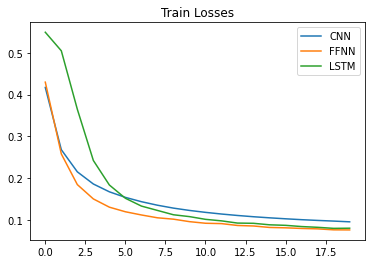

In [169]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, len(loss_cnn))), loss_cnn, label='CNN')
plt.plot(list(range(0, len(loss_ffnn))), loss_ffnn, label='FFNN')
plt.plot(list(range(0, len(loss_lstm))), loss_lstm, label='LSTM')
plt.legend()
plt.title('Train Losses')
plt.show()